In [1]:
from animationpipeline import AnimateInferPipeline, use_raw_vid, use_vid_key_points
from src.utils.util import get_fps, read_frames, save_videos_from_pil, save_videos_grid
from src.dwpose import DWposeDetector
from PIL import Image
import matplotlib.pyplot as plt
from tools.openpose_rescaler import draw, rescale_skeleton
from tools import openpose_rescaler
import importlib
from IPython.display import Video
import json
import cv2
import numpy as np
import copy
import torch

[2024-02-23 11:48:13,808] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/root/miniconda3/envs/animateAnyone/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/root/miniconda3/envs/animateAnyone/lib/python3.10/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/root/miniconda3/envs/animateAnyone/lib/python3.10/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_11m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being regist

In [2]:
detector = DWposeDetector().to('cuda')

2024-02-23 11:48:24.294391763 [W:onnxruntime:, session_state.cc:1162 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-02-23 11:48:24.294413978 [W:onnxruntime:, session_state.cc:1164 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


In [3]:
animator = AnimateInferPipeline(
    base_model_path='./pretrained_weights/stable-diffusion-v1-5',
    reference_unet_path="/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/pretrained_weights/opensource_stage1/reference_unet-0.pth",
    denoising_unet_path="/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/pretrained_weights/opensource_stage1/denoising_unet-0.pth", 
    vae_path='./pretrained_weights/sd-vae-ft-mse',
    pose_guider_path="/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/pretrained_weights/opensource_stage1/pose_guider-0.pth",
    motion_module_path="/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/stage2_out/mmV3_nonclip_withHDTF/motion_module-4641.pth",
    image_encoder_path='./pretrained_weights/sd-image-variations-diffusers/image_encoder',
    infer_config_path="/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/configs/inference/inference_v2.yaml",
    # lora_path="/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/stage2_out/mmV3_lora_full_data_5e-5/lora-2604.pth",
    # motion_module_path='/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/pretrained_weights/v3_sd15_mm.ckpt'
)

Some weights of the model checkpoint were not used when initializing UNet2DConditionModel: 
 ['conv_norm_out.bias, conv_norm_out.weight, conv_out.bias, conv_out.weight']
/root/miniconda3/envs/animateAnyone/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
torch.cuda.empty_cache()

(-0.5, 511.5, 511.5, -0.5)

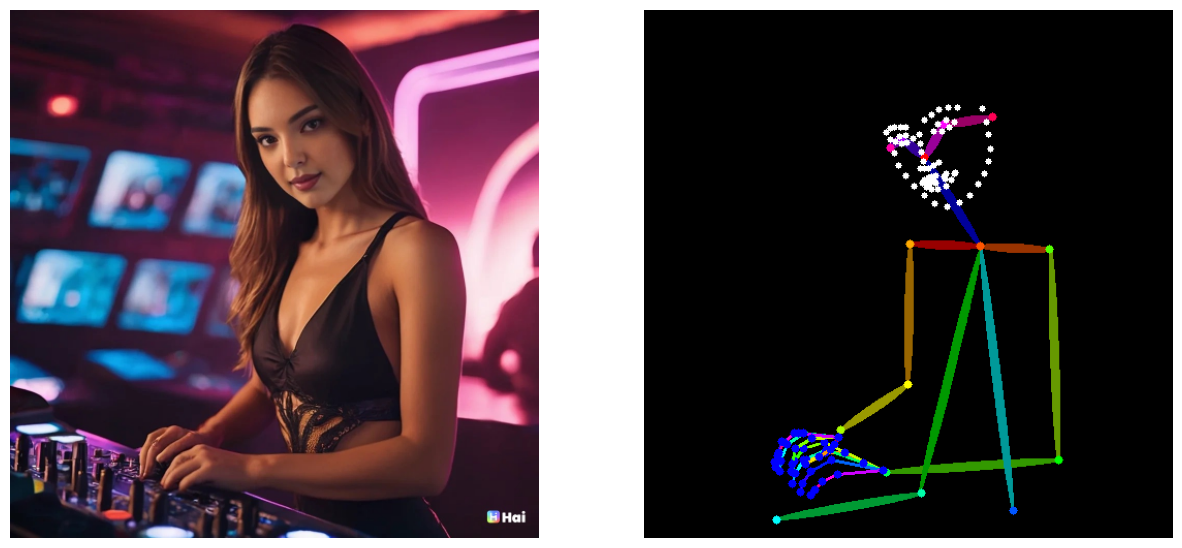

In [9]:
image_dir = "/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/assets/ref_image/bella_dj_1.png"

H = 512
W = 512

ref_image = cv2.resize(np.array(Image.open(image_dir)), (W,H))
ref_pose, score, ref_pose_keypoints = detector(ref_image, output_type='key_points')

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].imshow(ref_image)
axs[1].imshow(ref_pose)
axs[0].axis('off')
axs[1].axis('off')

In [10]:
use_raw = 1

raw_video_dir = '/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/assets/video_clips/dj.mp4'

pose_vid_dir = '/cephfs/SZ-AI/usr/liuchenyu/HaiLook/vid_dataset_hdtf_tiktok/videos_dwpose/00054.mp4'

if use_raw:
    pil_vid, pose_vid_dir = use_raw_vid(
        raw_video_dir,
        W,
        H,
        detector,
        'dj',
        # ref_pose_keypoints,
        start_frame=0,
        end_frame=320
    )
    
else:
    pil_vid = read_frames(pose_vid_dir)
    print("Loaded dwpose frames, total frames =", len(pil_vid))
    
for i in range(len(pil_vid)):
        pil_vid[i] = Image.fromarray(cv2.resize(np.array(pil_vid[i]), (W,H), interpolation=cv2.INTER_LINEAR))
        

total_frames:  320


100%|██████████| 320/320 [00:08<00:00, 36.19it/s]


---------------Saved original keypoints-------------------
---------------Saved rescaled dwpose video----------------


In [11]:
res_vid = animator.animate(
    ref_image=ref_image, 
    pose_list=pil_vid, 
    width=W, 
    height=H,
    video_length=160,
    num_inference_steps=20,
    cfg=3.5,
    seed=42,
    context_frames=16
)

torch.cuda.empty_cache()

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 160/160 [00:06<00:00, 25.11it/s]


In [13]:
save_video_name = 'mmV3_nonresize_dj'

save_video_dir = '/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/output/inference/' + save_video_name + '.mp4'

save_videos_grid(res_vid, save_video_dir,n_rows=1,fps=30)

Video(save_video_dir)